### Importing all the libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import f_regression, f_classif, SelectKBest, chi2, VarianceThreshold, RFE
from mlxtend.feature_selection import ExhaustiveFeatureSelector as EFS
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier

# import warnings filter
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)

### Creating a baseline model

Creating a baseline model without pre-processing helps set realistic performance expectations, identifies potential data issues, informs resource allocation decisions, and serves as a benchmark for comparing more complex models.

In [2]:
df = pd.read_csv('https://docs.google.com/spreadsheets/d/e/2PACX-1vQtBXo5cBnDsM2fmfHPm6u72KGUS5FjPHNGMxOfYjA9-CAhmnRpwkIw_rOR3sANJIToiUU__6fbBvig/pub?gid=572763137&single=true&output=csv')
df.head()

,Time,0,1,2,3,4,5,6,7,8,...,581,582,583,584,585,586,587,588,589,Pass/Fail
0,2008-07-19 11:55:00,3030.93,2564.00,2187.7333,1411.1265,1.3602,100.0,97.6133,0.1242,1.5005,...,NaN,0.5005,0.0118,0.0035,2.3630,NaN,NaN,NaN,NaN,-1
1,2008-07-19 12:32:00,3095.78,2465.14,2230.4222,1463.6606,0.8294,100.0,102.3433,0.1247,1.4966,...,208.2045,0.5019,0.0223,0.0055,4.4447,0.0096,0.0201,0.0060,208.2045,-1
2,2008-07-19 13:17:00,2932.61,2559.94,2186.4111,1698.0172,1.5102,100.0,95.4878,0.1241,1.4436,...,82.8602,0.4958,0.0157,0.0039,3.1745,0.0584,0.0484,0.0148,82.8602,1
3,2008-07-19 14:43:00,2988.72,2479.90,2199.0333,909.7926,1.3204,100.0,104.2367,0.1217,1.4882,...,73.8432,0.4990,0.0103,0.0025,2.0544,0.0202,0.0149,0.0044,73.8432,-1
4,2008-07-19 15:22:00,3032.24,2502.87,2233.3667,1326.5200,1.5334,100.0,100.3967,0.1235,1.5031,...,NaN,0.4800,0.4766,0.1045,99.3032,0.0202,0.0149,0.0044,73.8432,-1


In [3]:
df.shape

(1567, 592)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1567 entries, 0 to 1566
Columns: 592 entries, Time to Pass/Fail
dtypes: float64(590), int64(1), object(1)
memory usage: 7.1+ MB


We can see there is one Object dtype column. Let's find out which column is this.

In [5]:
for column in df.columns:
    if df[column].dtype == 'object':
        print(column)

Time


**Time** column does not play significance in our predictions. Therefore, we will drop this column.

In [6]:
df.drop(['Time'],axis=1,inplace=True)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1567 entries, 0 to 1566
Columns: 591 entries, 0 to Pass/Fail
dtypes: float64(590), int64(1)
memory usage: 7.1 MB


Now our Dataset is purely numerical.

we can see magnitude of features is different. When the magnitudes of features are significantly different, it can affect the performance of certain machine learning algorithms.

Target Column = [-1,  1] (Binary classification problem)

In [8]:
df.describe()

,0,1,2,3,4,5,6,7,8,9,...,581,582,583,584,585,586,587,588,589,Pass/Fail
count,1561.000000,1560.000000,1553.000000,1553.000000,1553.000000,1553.0,1553.000000,1558.000000,1565.000000,1565.000000,...,618.000000,1566.000000,1566.000000,1566.000000,1566.000000,1566.000000,1566.000000,1566.000000,1566.000000,1567.000000
mean,3014.452896,2495.850231,2200.547318,1396.376627,4.197013,100.0,101.112908,0.121822,1.462862,-0.000841,...,97.934373,0.500096,0.015318,0.003847,3.067826,0.021458,0.016475,0.005283,99.670066,-0.867262
std,73.621787,80.407705,29.513152,441.691640,56.355540,0.0,6.237214,0.008961,0.073897,0.015116,...,87.520966,0.003404,0.017180,0.003720,3.578033,0.012358,0.008808,0.002867,93.891919,0.498010
min,2743.240000,2158.750000,2060.660000,0.000000,0.681500,100.0,82.131100,0.000000,1.191000,-0.053400,...,0.000000,0.477800,0.006000,0.001700,1.197500,-0.016900,0.003200,0.001000,0.000000,-1.000000
25%,2966.260000,2452.247500,2181.044400,1081.875800,1.017700,100.0,97.920000,0.121100,1.411200,-0.010800,...,46.184900,0.497900,0.011600,0.003100,2.306500,0.013425,0.010600,0.003300,44.368600,-1.000000
50%,3011.490000,2499.405000,2201.066700,1285.214400,1.316800,100.0,101.512200,0.122400,1.461600,-0.001300,...,72.288900,0.500200,0.013800,0.003600,2.757650,0.020500,0.014800,0.004600,71.900500,-1.000000
75%,3056.650000,2538.822500,2218.055500,1591.223500,1.525700,100.0,104.586700,0.123800,1.516900,0.008400,...,116.539150,0.502375,0.016500,0.004100,3.295175,0.027600,0.020300,0.006400,114.749700,-1.000000
max,3356.350000,2846.440000,2315.266700,3715.041700,1114.536600,100.0,129.252200,0.128600,1.656400,0.074900,...,737.304800,0.509800,0.476600,0.104500,99.303200,0.102800,0.079900,0.028600,737.304800,1.000000


In [9]:
df.isnull().sum()

0             6
1             7
2            14
3            14
4            14
             ..
586           1
587           1
588           1
589           1
Pass/Fail     0
Length: 591, dtype: int64

There are null values in our dataset we need to remove these null values

In [10]:
df.fillna(df.median(),inplace=True)

In [11]:
df.isnull().sum()

0            0
1            0
2            0
3            0
4            0
            ..
586          0
587          0
588          0
589          0
Pass/Fail    0
Length: 591, dtype: int64

In [12]:
x = df.iloc[:,0:590]
y = df.iloc[:,-1]
xtrain, xtest, ytrain, ytest = train_test_split(x,y,test_size=0.2,random_state=42)
xtrain.shape,xtest.shape,ytrain.shape,ytest.shape

((1253, 590), (314, 590), (1253,), (314,))

In [13]:
lr = LogisticRegression()
model = lr.fit(xtrain,ytrain)

C:\Users\shubh\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [14]:
ypred = model.predict(xtest)
accuracy_score(ytest,ypred)

0.910828025477707

#### Check Duplicate Features

In [15]:
df = df.T.drop_duplicates().T
df.head()

,0,1,2,3,4,5,6,7,8,9,...,581,582,583,584,585,586,587,588,589,Pass/Fail
0,3030.93,2564.00,2187.7333,1411.1265,1.3602,100.0,97.6133,0.1242,1.5005,0.0162,...,72.2889,0.5005,0.0118,0.0035,2.3630,0.0205,0.0148,0.0046,71.9005,-1.0
1,3095.78,2465.14,2230.4222,1463.6606,0.8294,100.0,102.3433,0.1247,1.4966,-0.0005,...,208.2045,0.5019,0.0223,0.0055,4.4447,0.0096,0.0201,0.0060,208.2045,-1.0
2,2932.61,2559.94,2186.4111,1698.0172,1.5102,100.0,95.4878,0.1241,1.4436,0.0041,...,82.8602,0.4958,0.0157,0.0039,3.1745,0.0584,0.0484,0.0148,82.8602,1.0
3,2988.72,2479.90,2199.0333,909.7926,1.3204,100.0,104.2367,0.1217,1.4882,-0.0124,...,73.8432,0.4990,0.0103,0.0025,2.0544,0.0202,0.0149,0.0044,73.8432,-1.0
4,3032.24,2502.87,2233.3667,1326.5200,1.5334,100.0,100.3967,0.1235,1.5031,-0.0031,...,72.2889,0.4800,0.4766,0.1045,99.3032,0.0202,0.0149,0.0044,73.8432,-1.0


### Performing Feature selection

Performing feature selection after creating a baseline model allows you to systematically identify and retain the most relevant features, potentially enhancing model interpretability, reducing overfitting, and improving overall model performance. This iterative approach helps streamline the feature set and contributes to the development of more effective and efficient machine learning models.

In [16]:
X = df.drop('Pass/Fail', axis=1)
y = df['Pass/Fail']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [17]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1253, 478), (314, 478), (1253,), (314,))

#### Filter Methods 

In the context of machine learning, especially in feature selection or dimensionality reduction, a "filter" method typically refers to techniques that are applied before the actual training of a model. These techniques involve assessing and selecting features based on certain criteria, and the selected features are then used for training the machine learning model.

1. F-Regression : F-regression is commonly applied in regression tasks when you want to identify the most relevant features that contribute significantly to predicting the target variable.  It evaluates the linear relationship between each feature and the target variable.  Computes F-scores, which are used to measure the overall significance of each feature.
<br>
2. F-Classification (ANOVA): Used for classification tasks to assess the significance of features in predicting a categorical target variable. Computes ANOVA F-values, measuring the significance of feature variances across different classes.
<br>
3. Fisher score :  Often associated with Fisher's Linear Discriminant Analysis (LDA) in classification tasks. In classification, the Fisher score is calculated based on between-class and within-class variances. Used to find features that best separate classes in classification tasks.
<br>

when discussing feature selection in the context of classification tasks, terms like "Fisher score," "ANOVA F-value," and functions like f_classif are often used interchangeably because they all involve analyzing the variance between classes and within classes to assess the significance of features.
<br>

4. Variance threshold technique : It is applied on two types of features - constant and Quasi-constant features. 

    **Constant features** - Features with zero variance are considered constant because they have the same value across all 
       samples. We can drop these columns because they dont play an important factor while predicting the target column.
   
    **Quasi-Constant features** - Quasi-constant features have very low variance, indicating little variability across 
       samples. Quasi-constant features can be removed by variance threshold method.
       
    
    - **Calculation of Feature Variances**: For each feature in the dataset, 
    the algorithm calculates the variance. The variance is a measure of how 
    much the values of a feature vary across samples.

    - **Comparison with Threshold**:The algorithm compares the calculated  
    variances for each feature with a specified threshold. The threshold is 
    a user-defined value that determines the minimum amount of variance 
    required for a feature to be considered informative.

    - 
    **Identification of Low Variance Features**: Features with variances  
    below the specified threshold are identified. These features are deemed 
    to have low variability and are candidates for removal.

<br>
5. Correlation : Correlation-based feature selection is a filter method that involves evaluating the correlation between features and selecting or removing features based on their correlation with the target variable or with other features. 

6. Mutual Information: Mutual Information (MI) is a measure of the statistical dependence or information shared between two random variables. In the context of feature selection (FS), mutual information is used to assess the relationship between a feature and the target variable. It quantifies the amount of information that knowing the value of one variable provides about the other.

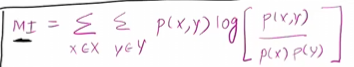

In the context of feature selection, mutual information is often used to assess the information gain provided by each feature with respect to the target variable. The higher the mutual information, the more information the feature provides about the target, suggesting that it might be a relevant and informative feature.


##### Variance threshold technique

In [18]:
# Calculate variance for each column
variance_per_column = df.var()

print("Variance of each column:")
print(variance_per_column)

Variance of each column:
0              5399.434065
1              6436.555001
2               863.241583
3            193456.876750
4              3147.627515
                 ...      
586               0.000153
587               0.000078
588               0.000008
589            8810.555216
Pass/Fail         0.248014
Length: 479, dtype: float64


In [19]:
sel = VarianceThreshold(threshold=0.09)
sel.fit(X_train)

VarianceThreshold(threshold=0.09)

In [20]:
f"Number of columns having variance less than 0.09 are {sum(sel.get_support())}"

'Number of columns having variance less than 0.09 are 273'

In [21]:
columns = X_train.columns[sel.get_support()]
columns  # those columns whose variance > 0.09

Index(['0', '1', '2', '3', '4', '6', '12', '14', '15', '16',
       ...
       '568', '569', '570', '572', '574', '576', '577', '581', '585', '589'],
      dtype='object', length=273)

In [22]:
# deleting columns whose variance is less than threshold

X_train = sel.transform(X_train)
X_test = sel.transform(X_test)

In [23]:
X_train = pd.DataFrame(X_train, columns=columns)
X_test = pd.DataFrame(X_test, columns=columns)

print(X_train.shape)
print(X_test.shape)

(1253, 273)
(314, 273)


**Points to Consider While applying variance threshold method:**

1. **Ignores Target Variable**: Variance Threshold is a univariate method, meaning it evaluates each feature independently and doesn't consider the relationship between each feature and the target variable. This means it may keep irrelevant features that have a high variance but no relationship with the target, or discard potentially useful features that have a low variance but a strong relationship with the target.
<br>
2. **Ignores Feature Interactions**: Variance Threshold doesn't account for interactions between features. A feature with a low variance may become very informative when combined with another feature.

##### Anova

In [24]:
sel = SelectKBest(f_classif, k=100).fit(X_train, y_train)

# display selected feature names
X_train.columns[sel.get_support()]

Index(['0', '14', '21', '22', '27', '28', '31', '32', '33', '37', '38', '40',
       '59', '62', '63', '64', '65', '66', '67', '70', '90', '111', '115',
       '122', '129', '133', '138', '159', '160', '165', '180', '183', '188',
       '195', '196', '197', '198', '199', '200', '203', '204', '205', '207',
       '225', '294', '295', '316', '318', '319', '324', '332', '333', '335',
       '336', '337', '340', '341', '343', '363', '388', '411', '417', '418',
       '423', '430', '431', '433', '434', '435', '436', '437', '452', '453',
       '455', '460', '467', '468', '469', '470', '471', '475', '477', '479',
       '484', '488', '494', '497', '510', '511', '519', '521', '522', '550',
       '551', '553', '554', '556', '557', '561', '577'],
      dtype='object')

In [25]:
columns = X_train.columns[sel.get_support()] # those columns which are statisticallly significant

X_train = sel.transform(X_train) # remove bekar columns
X_test = sel.transform(X_test)

X_train = pd.DataFrame(X_train, columns=columns)
X_test = pd.DataFrame(X_test, columns=columns)
print(X_train.shape)
print(X_test.shape)

(1253, 100)
(314, 100)


In [26]:
X_train.head()

,0,14,21,22,27,28,31,32,33,37,...,521,522,550,551,553,554,556,557,561,577
0,2951.41,6.3185,-5679.00,2707.00,7.3467,68.1778,3.3762,85.5573,8.6915,66.1976,...,0.0,10.4315,14.00,2.30,6.5454,0.9398,3.4256,2.8371,71.0573,8.6470
1,2998.89,6.5451,-5525.25,2653.50,7.1732,71.9444,3.1998,84.5250,8.7932,66.2803,...,0.0,11.3839,16.34,1.15,7.4279,0.4789,4.0671,1.5298,68.3558,13.2830
2,3083.49,10.2250,-5595.75,2789.25,7.1750,67.2444,3.2781,85.5361,8.5360,66.2273,...,0.0,10.6510,16.34,1.15,7.4279,0.4789,4.0671,1.5298,23.3263,14.9920
3,3004.09,4.2144,-4490.50,2320.25,2.2685,63.6000,3.5009,85.1197,9.1784,66.5600,...,0.0,10.3963,15.45,0.47,6.2498,0.2144,3.8721,0.6519,32.2583,12.0404
4,3031.79,7.5919,-6401.25,3096.75,5.0157,71.0000,4.6093,84.8700,9.4832,66.4374,...,0.0,15.1569,16.34,1.15,7.4279,0.4789,4.0671,1.5298,95.8686,13.3366


In [27]:
# let's now implement ML model on our selected features and see results

log_reg = LogisticRegression()  # Increase max_iter if it doesn't converge
log_reg.fit(X_train, y_train)

# Make predictions on the test set
y_pred = log_reg.predict(X_test)

# Calculate and print accuracy score
accuracy = accuracy_score(y_test, y_pred)
print("Test accuracy:", accuracy)

Test accuracy: 0.9235668789808917


C:\Users\shubh\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


**Our Accuracy Increased !!!**

When feature reduction leads to an increase in accuracy, it indicates that the selected features contain more relevant information for the model, reducing noise and improving generalization. By focusing on the most informative features, the model can better capture the underlying patterns in the data, resulting in improved predictive performance. Feature selection helps eliminate irrelevant or redundant information, enhancing the model's ability to discern meaningful relationships and contribute to higher accuracy.

##### chi squared test

Used when both input & output columns are categorical.  The chi-squared test for feature selection is a statistical test used to determine if there is a significant association between categorical variables. It is often employed in feature selection when dealing with categorical or discrete data.

**Null Hypothesis (H0)**: There is no significant association between the two categorical variables.
<br>
**Alternative Hypothesis (H1)**: There is a significant association between the two categorical variables.

Create a contingency table - observed and expected. Observed is directly crosstabulated from the raw data and by using observed table u can create expected contingency table via the formula :
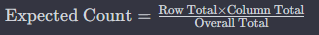
<br>
Compute the chi-squared statistic. Compare the calculated chi-squared statistic with the critical value from the chi-squared distribution table at the chosen significance level and degrees of freedom. 
If the calculated chi-squared statistic is greater than the critical value, reject the null hypothesis and conclude that there is a significant association between the variables.

for understanding chi2 - https://www.kaggle.com/code/campusx/filter-based-feature-selection/notebook

In [76]:
df = pd.read_csv('train.csv')
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [77]:
df.drop(['Name','Ticket','PassengerId','Cabin','Age','Fare'],axis=1,inplace=True)

In [78]:
df.head()

,Survived,Pclass,Sex,SibSp,Parch,Embarked
0,0,3,male,1,0,S
1,1,1,female,1,0,C
2,1,3,female,0,0,S
3,1,1,female,1,0,S
4,0,3,male,0,0,S


In [79]:
df.isnull().sum()

Survived    0
Pclass      0
Sex         0
SibSp       0
Parch       0
Embarked    2
dtype: int64

In [80]:
modeval = df['Embarked'].mode()
modeval

0    S
Name: Embarked, dtype: object

In [81]:
df['Embarked'].fillna('S',inplace=True)

In [82]:
df.isnull().sum()

Survived    0
Pclass      0
Sex         0
SibSp       0
Parch       0
Embarked    0
dtype: int64

In [83]:
df.head()

,Survived,Pclass,Sex,SibSp,Parch,Embarked
0,0,3,male,1,0,S
1,1,1,female,1,0,C
2,1,3,female,0,0,S
3,1,1,female,1,0,S
4,0,3,male,0,0,S


In [84]:
# Encode categorical variables

from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
df = df.apply(le.fit_transform)
df.head()

,Survived,Pclass,Sex,SibSp,Parch,Embarked
0,0,2,1,1,0,2
1,1,0,0,1,0,0
2,1,2,0,0,0,2
3,1,0,0,1,0,2
4,0,2,1,0,0,2


In [85]:
x,y = df.iloc[:,1:],df.iloc[:,0]

In [86]:
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.2,random_state=42)

In [87]:
x_train.shape,y_train.shape

((712, 5), (712,))

In [90]:
# training a baseline model

log_reg = LogisticRegression()  
log_reg.fit(x_train, y_train)

y_pred = log_reg.predict(x_test)

accuracy = accuracy_score(y_test, y_pred)
train_scores = cross_val_score(log_reg, x_train, y_train, cv=5, scoring='accuracy')
test_scores = cross_val_score(log_reg, x_test, y_test, cv=5, scoring='accuracy')

In [92]:
print('For baseline model: ')

print("Test accuracy:", accuracy)
print("cv train score: ",train_scores.mean())
print("cv test score", test_scores.mean())

For baseline model: 
Test accuracy: 0.770949720670391
cv train score:  0.7935093075938146
cv test score 0.7487301587301587


###### Doing Feature selection now - applying chi2 test

In [139]:
df = pd.read_csv('train.csv')
df.drop(['Name','Ticket','PassengerId','Cabin','Age','Fare'],axis=1,inplace=True)
df['Embarked'].fillna('S',inplace=True)
le = LabelEncoder()
df = df.apply(le.fit_transform)
x,y = df.iloc[:,1:],df.iloc[:,0]
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.2,random_state=42)

In [140]:
skbest = SelectKBest(chi2,k='all').fit(x_train,y_train)
x_train.columns[skbest.get_support()] 

Index(['Pclass', 'Sex', 'SibSp', 'Parch', 'Embarked'], dtype='object')

In [141]:
skbest.scores_

array([37.62770113, 71.90588207,  2.20802248,  7.20641836,  6.5277615 ])

The scores_ attribute will contain a value for each feature, representing the computed chi-squared statistic for that feature. The higher the score, the more likely the feature is considered relevant or informative for the target variable.

**Computing the P-value**

In [142]:
chi_scores = chi2(x_train, y_train)

# chi_scores[1] are the p-values of each feature.
p_values = pd.Series(chi_scores[1], index = x_train.columns)
p_values.sort_values(inplace = True)

In [148]:
def format_scientific_to_decimal(number):
    return "{:.17f}".format(number)

# Apply the formatting function to the entire Series
formatted_p_values = p_values.apply(format_scientific_to_decimal)

formatted_p_values

Sex         0.00000000000000002
Pclass      0.00000000085619883
Parch       0.00726433168053145
Embarked    0.01062035300220470
SibSp       0.13729456547539698
dtype: object

**SibSp**  has relatively low chi-sq statistic as well as p-value states there is no significant association with target col. let's remove it and train our model

In [144]:
x_train.drop(['SibSp'],axis=1,inplace=True)
x_test.drop(['SibSp'],axis=1,inplace=True)

In [145]:
# training a baseline model

log_reg = LogisticRegression()  
log_reg.fit(x_train, y_train)

y_pred = log_reg.predict(x_test)

accuracy = accuracy_score(y_test, y_pred)
train_scores = cross_val_score(log_reg, x_train, y_train, cv=5, scoring='accuracy')
test_scores = cross_val_score(log_reg, x_test, y_test, cv=5, scoring='accuracy')

In [146]:
print("Test accuracy:", accuracy)
print("cv train score: ",train_scores.mean())
print("cv test score", test_scores.mean())

Test accuracy: 0.776536312849162
cv train score:  0.7878755047769133
cv test score 0.7544444444444445


**Accuracy Increased !!**

**Mutual Info Gain**

In [98]:
from sklearn.feature_selection import mutual_info_classif
from sklearn.datasets import load_iris

# Load iris dataset
iris = load_iris()
X = iris['data']
y = iris['target']

# Compute mutual information
mi = mutual_info_classif(X, y)
mi

array([0.48907325, 0.27610799, 0.97908134, 0.99042048])

In [99]:
type(mi)

numpy.ndarray

In [100]:
# Print mutual information
for i, mi_value in enumerate(mi):
    print(f"Feature {iris.feature_names[i]}: Mutual Information = {mi_value}")

Feature sepal length (cm): Mutual Information = 0.4890732498679544
Feature sepal width (cm): Mutual Information = 0.27610799357518867
Feature petal length (cm): Mutual Information = 0.9790813379032381
Feature petal width (cm): Mutual Information = 0.9904204831530408


#### Wrapper Methods

Wrapper methods for feature selection are techniques that assess different subsets of features by using a machine learning model's performance as an evaluation criterion. Unlike filter methods that rely on statistical measures or heuristics, wrapper methods involve training and evaluating the model with different subsets of features to identify the optimal set.

##### Exhaustive Feature Selection

Exhaustive Feature Selection is a wrapper method for feature selection that evaluates all possible feature combinations to identify the subset that optimizes a specified performance metric. Unlike forward selection or backward elimination, which iteratively add or remove features, exhaustive feature selection systematically evaluates every possible subset of features.

The biggest drawback is its computational cost. If you have n features, the number of combinations to check is 2^n-1. So, as the number of features
grows, the number of combinations grows exponentially, making this method
computationally expensive and time-consuming. For datasets with a large number of features, it may not be practical.

 **For Classification Tasks**

##### training a baseine model

In [23]:
df = pd.read_csv('https://gist.githubusercontent.com/curran/a08a1080b88344b0c8a7/raw/0e7a9b0a5d22642a06d3d5b9bcbad9890c8ee534/iris.csv')
df.head()

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


In [24]:
df.shape

(150, 5)

In [37]:
x,y = df.iloc[:,:4],df['species']

In [38]:
lr = LogisticRegression()

sel = EFS(lr, max_features=4, scoring='accuracy', cv=5)
sel

ExhaustiveFeatureSelector(estimator=LogisticRegression(), max_features=4)

In [39]:
model = sel.fit(x,y)

C:\Users\shubh\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\shubh\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

In [40]:
model.best_score_

0.9733333333333334

In [41]:
model.best_feature_names_

('sepal_width', 'petal_length', 'petal_width')

**hence, we can see the subset of 'sepal_width', 'petal_length', 'petal_width' gives the best results for our classification dataset**

**For Regression Tasks**

In [42]:
df = pd.read_csv('https://raw.githubusercontent.com/selva86/datasets/master/BostonHousing.csv')
df.head()

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,b,lstat,medv
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2


In [43]:
df.shape

(506, 14)

In [44]:
X_train, X_test, y_train, y_test = train_test_split(df.iloc[:,:-1], df['medv'], test_size=0.2, random_state=1)

In [46]:
X_train.head()

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,b,lstat
42,0.14150,0.0,6.91,0,0.448,6.169,6.6,5.7209,3,233,17.9,383.37,5.81
58,0.15445,25.0,5.13,0,0.453,6.145,29.2,7.8148,8,284,19.7,390.68,6.86
385,16.81180,0.0,18.10,0,0.700,5.277,98.1,1.4261,24,666,20.2,396.90,30.81
78,0.05646,0.0,12.83,0,0.437,6.232,53.7,5.0141,5,398,18.7,386.40,12.34
424,8.79212,0.0,18.10,0,0.584,5.565,70.6,2.0635,24,666,20.2,3.65,17.16


In [47]:
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [50]:
# baseline model

model = LinearRegression()

print("training",np.mean(cross_val_score(model, X_train, y_train, cv=5, scoring='r2')))
print("testing",np.mean(cross_val_score(model, X_test, y_test, cv=5, scoring='r2')))

training 0.7025123301096213
testing 0.6514899901155404


In [51]:
# applying EFS on regression data

lr = LinearRegression()
exh = EFS(lr, max_features=13, scoring='r2', cv=10, print_progress=True,n_jobs=-1)
sel = exh.fit(X_train, y_train)

Features: 6980/8191IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Features: 8191/8191

In [52]:
sel.best_score_

0.6827988156800066

In [53]:
sel.best_feature_names_

('0', '1', '4', '5', '7', '8', '9', '10', '11', '12')

In [54]:
X_train_sel = sel.transform(X_train)
X_test_sel = sel.transform(X_test)

In [55]:
model = LinearRegression()

print("training",np.mean(cross_val_score(model, X_train_sel, y_train, cv=5, scoring='r2')))
print("testing",np.mean(cross_val_score(model, X_test_sel, y_test, cv=5, scoring='r2')))

training 0.7100327839218561
testing 0.7205819296124483


##### Sequential Backward Elimination

Sequential Backward Elimination (SBE) is a feature selection technique where you start with all the features in your dataset and iteratively remove one feature at a time until a certain stopping criterion is met. The goal is to improve model performance by eliminating less important or redundant features.

number of iterations(n) = number of features in your dataset.

This method is way faster than exhaustive feature selection.

In [66]:
data = pd.read_csv('https://raw.githubusercontent.com/selva86/datasets/master/BostonHousing.csv')
data.head()

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,b,lstat,medv
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2


In [67]:
# separate the target variable
X = data.drop("medv", axis=1)
y = data['medv']

# split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

In [68]:
# bringing everything to same scale 

sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [69]:
# baseline model

model = LinearRegression()

print("training",np.mean(cross_val_score(model, X_train, y_train, cv=5, scoring='r2')))
print("testing",np.mean(cross_val_score(model, X_test, y_test, cv=5, scoring='r2')))

training 0.7025123301096213
testing 0.6514899901155404


In [70]:
# applying SBE Method 

lr = LinearRegression()

# perform backward elimination
sbe = SFS(lr, k_features='best', forward=False, floating=False, scoring='r2',cv=5)
sbe.fit(X_train, y_train)

SequentialFeatureSelector(estimator=LinearRegression(), forward=False,
                          k_features=(1, 13), scoring='r2')

In [71]:
# best columns according to SFS

for i in list(sbe.k_feature_idx_):
    print(X.columns[i])

crim
zn
nox
rm
dis
rad
tax
ptratio
b
lstat


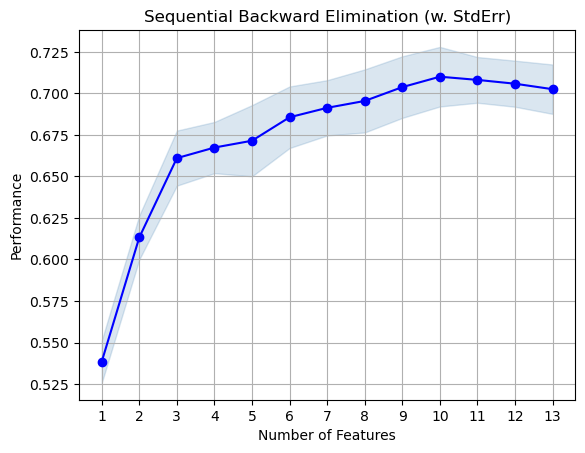

In [75]:
fig1 = plot_sfs(sfs.get_metric_dict(), kind='std_err',)

plt.title('Sequential Backward Elimination (w. StdErr)')
plt.grid()
plt.show()

In [76]:
X_train_sel = sfs.transform(X_train)
X_test_sel = sfs.transform(X_test)

model = LinearRegression()

print("training",np.mean(cross_val_score(model, X_train_sel, y_train, cv=5, scoring='r2')))
print("testing",np.mean(cross_val_score(model, X_test_sel, y_test, cv=5, scoring='r2')))

training 0.7100327839218561
testing 0.7205819296124483


##### **Recursive Feature Elimination**

Recursive Feature Elimination (RFE) is a feature selection technique that works by recursively removing the least important features from the model until the desired number of features is reached. It ranks features based on their contribution to the model and iteratively eliminates the least significant ones. RFE is particularly useful when you have a large number of features and want to identify a subset that provides the best model performance.

In [77]:
df = pd.read_csv('https://gist.githubusercontent.com/curran/a08a1080b88344b0c8a7/raw/0e7a9b0a5d22642a06d3d5b9bcbad9890c8ee534/iris.csv')
df.head()

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


In [80]:
df.shape

(150, 5)

In [78]:
X = df.iloc[:,0:-1]
y = df.iloc[:,-1]

In [84]:
model = RandomForestClassifier()

In [85]:
rfe = RFE(estimator=model,n_features_to_select=1)
rfe.fit(X,y)

RFE(estimator=RandomForestClassifier(), n_features_to_select=1)

In [87]:
rfe_rank = rfe.ranking_

In [93]:
feature_selected = pd.DataFrame({'Feature':X.columns,'RFE Rank':rfe_rank})
feature_selected.sort_values(by='RFE Rank')

,Feature,RFE Rank
2,petal_length,1
3,petal_width,2
0,sepal_length,3
1,sepal_width,4


Petal Length is considered the most important feature.
Petal Width is considered the second most important feature.
Sepal Length is considered the third most important feature.
Sepal Width is considered the least important feature.

Depending on your goals and the characteristics of your dataset, you might decide to keep the top k features. For example, if you decide to keep the top 3 features, you would retain Petal Length, Petal Width, and Sepal Length while excluding Sepal Width.

RFE rankings are specific to the machine learning model used during the RFE process. Different models may yield different rankings.

**Embedded Feature selection**

Embedded feature selection is a technique where feature selection is incorporated directly into the process of training a machine learning model. In other words, feature selection becomes an inherent part of the learning algorithm rather than a separate pre-processing step. The model itself decides which features are important during the training process. This is in contrast to filter or wrapper methods, where feature selection is performed before the model is trained.

Embedded methods can be applied to those ML models having either coef_ or feature_importance_ in them.

##### Using regression

In [2]:
df = pd.read_csv('https://raw.githubusercontent.com/npradaschnor/Pima-Indians-Diabetes-Dataset/master/diabetes.csv')
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


Let's apply Lasso regression and predict which features are the most important features

In [3]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df.iloc[:,0:-1],df.iloc[:,-1],test_size=0.2,random_state=1)

In [5]:
X_train.shape

(614, 8)

In [6]:
from sklearn.preprocessing import StandardScaler

cols = X_train.columns

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_scaled = pd.DataFrame(X_train_scaled,columns=cols)
X_test_scaled = pd.DataFrame(X_test_scaled,columns=cols)

In [7]:
X_train_scaled.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
0,1.516591,0.750524,0.564756,1.652015,0.437496,0.795825,0.529526,0.567932
1,1.812018,0.244752,-0.347904,1.020973,-0.678474,1.228654,-0.069689,0.398450
2,0.925736,-0.608739,0.260536,1.273390,0.222886,0.704013,-0.794249,0.991638
3,1.221164,-0.039745,0.463350,-1.250779,-0.678474,-0.896139,-0.167519,2.601722
4,-0.551400,-0.039745,0.361943,1.084077,0.222886,1.031914,-0.760619,-0.364222


In [11]:
from sklearn.linear_model import Lasso

lasso = Lasso(alpha=0.01)

lasso.fit(X_train_scaled, y_train)

Lasso(alpha=0.01)

In [12]:
lasso.coef_

array([ 6.26290474e-02,  1.85968700e-01, -3.50258983e-02, -0.00000000e+00,
       -1.62558777e-04,  8.51781764e-02,  2.83810683e-02,  1.84611338e-02])

<Axes: >

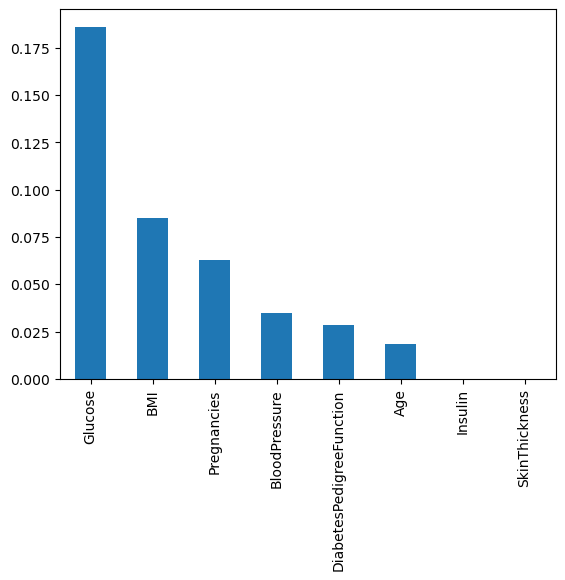

In [13]:
import matplotlib.pyplot as plt
import numpy as np

x = pd.Series(np.abs(lasso.coef_),index=cols)

x.sort_values(ascending=False).plot(kind='bar')

In Lasso regression, increasing the regularization parameter (often denoted as λ or alpha) promotes sparsity in feature selection. Let's break down the concept in simpler terms:

Lasso Regression:
Lasso (Least Absolute Shrinkage and Selection Operator) is a type of linear regression that includes a regularization term in its objective function. The regularization term is a penalty based on the absolute values of the coefficients. The regularization parameter λ controls the strength of the penalty. When λ is increased, the impact of the regularization term becomes more significant. Higher λ values lead to a stronger penalty on the absolute values of the coefficients.

This is what we mean by "sparsity" in feature selection. Essentially, Lasso tends to shrink some coefficients to exactly zero, effectively eliminating the corresponding features from the model.

##### Using classification - Decision Trees

In [15]:
df = pd.read_csv('https://raw.githubusercontent.com/npradaschnor/Pima-Indians-Diabetes-Dataset/master/diabetes.csv')
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [16]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df.iloc[:,0:-1],df.iloc[:,-1],test_size=0.2,random_state=1)

In [17]:
from pandas.core.common import random_state
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

dt = DecisionTreeClassifier()
rf = RandomForestClassifier()

#dt.fit(X_train,y_train)
rf.fit(X_train,y_train)

RandomForestClassifier()

In [18]:
rf.feature_importances_

array([0.08214881, 0.25676126, 0.08902054, 0.06930536, 0.08032952,
       0.16660125, 0.12742998, 0.12840327])

<Axes: >

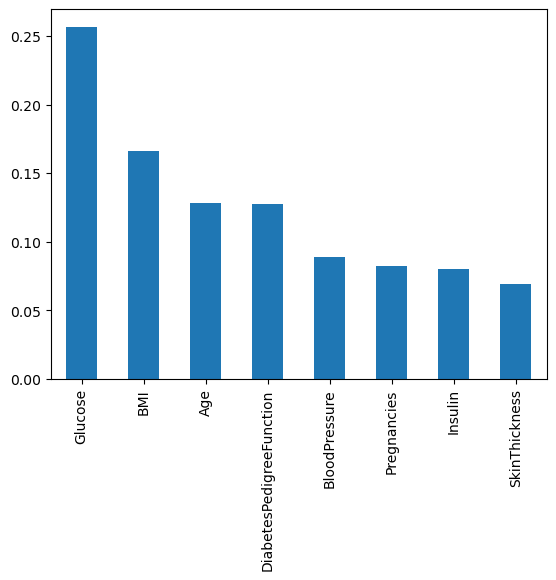

In [19]:
x = pd.Series(np.abs(rf.feature_importances_),index=cols)

x.sort_values(ascending=False).plot(kind='bar')

##### Using SelectFromModel

In [20]:
df = pd.read_csv('https://raw.githubusercontent.com/npradaschnor/Pima-Indians-Diabetes-Dataset/master/diabetes.csv')

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df.iloc[:,0:-1],df.iloc[:,-1],test_size=0.2,random_state=1)

In [21]:
from sklearn.tree import DecisionTreeClassifier

model = DecisionTreeClassifier()

In [22]:
from sklearn.feature_selection import SelectFromModel

sfm = SelectFromModel(model, threshold=0.1)

In [23]:
sfm.fit(X_train, y_train)

SelectFromModel(estimator=DecisionTreeClassifier(), threshold=0.1)

In [24]:
sfm.get_support(indices=True)

array([1, 2, 5, 6, 7], dtype=int64)

In [25]:
sfm.feature_names_in_[sfm.get_support(indices=True)]

array(['Glucose', 'BloodPressure', 'BMI', 'DiabetesPedigreeFunction',
       'Age'], dtype=object)

In [26]:
X_train_trans = sfm.transform(X_train)

X_train_trans = pd.DataFrame(X_train_trans,columns=sfm.feature_names_in_[sfm.get_support(indices=True)])

X_train_trans

,Glucose,BloodPressure,BMI,DiabetesPedigreeFunction,Age
0,145.0,80.0,37.9,0.637,40.0
1,129.0,62.0,41.2,0.441,38.0
2,102.0,74.0,37.2,0.204,45.0
3,120.0,78.0,25.0,0.409,64.0
4,120.0,76.0,39.7,0.215,29.0
...,...,...,...,...,...
609,157.0,74.0,39.4,0.134,30.0
610,187.0,50.0,33.9,0.826,34.0
611,126.0,90.0,43.4,0.583,42.0
612,171.0,72.0,43.6,0.479,26.0
